In [1]:

# Standard Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random
from collections import defaultdict
from collections import Counter
from scipy.ndimage import gaussian_filter1d

# Scikit-learn Libraries
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    StackingRegressor,
    ExtraTreesRegressor
)
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)
from sklearn.model_selection import (
    RandomizedSearchCV,
    GridSearchCV,
    cross_val_score,
    train_test_split
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet, Ridge

# XGBoost
from xgboost import XGBRegressor

# LightGBM
from lightgbm import LGBMRegressor

# CatBoost
from catboost import CatBoostRegressor
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv('/kaggle/input/anl-updated/final_ANL-Intrepid-2009.swf (1).csv')
X = df.drop(['run_time'], axis=1)
y = df['run_time']

In [3]:
X_train,X_test,Y_train,Y_test = train_test_split(X, y, test_size=0.25,random_state=42)
X_train,X_val,Y_train,Y_val =train_test_split(X, y, test_size=0.25,random_state=42)

In [44]:
class MachineLearning:
    def __init__(self,X_train,X_val,X_test,Y_train,Y_val,Y_test):
        self.X_train = X_train
        self.X_val = X_val
        self.X_test = X_test
        self.Y_train = Y_train
        self.Y_val = Y_val
        self.Y_test = Y_test

        self.configs = {
            "knn": {"n_neighbors": 3, "weights": "uniform", "algorithm": "auto", "leaf_size": 30, "p": 2},
            "linearreg": {"fit_intercept": False, "copy_X": True, "n_jobs": -1},
            "mlp": {"hidden_layer_sizes": (100,), "activation": "relu", "solver": "adam", "max_iter": 500},
            "decisiontree": {"criterion": "squared_error", "max_depth": 20, "min_samples_split": 3},
            "randomforest": {"n_estimators": 100, "criterion": "squared_error", "max_depth": None, "min_samples_split": 2},
            "xgboost": {"n_estimators": 100, "learning_rate": 0.1, "max_depth": 3, "verbosity": 1},
            "gradientboosting": {"loss": "squared_error", "learning_rate": 0.1, "n_estimators": 100, "subsample": 1.0},
            "extratrees": {"n_estimators": 50, "max_depth": None, "min_samples_split": 2, "random_state": 42},
            "lightgbm": {"n_estimators": 100, "learning_rate": 0.1, "max_depth": -1, "num_leaves": 31, "random_state": 42},
            "catboost": {"iterations": 100, "learning_rate": 0.1, "depth": 6, "verbose": False},
            "lasso": {"alpha": 1.0,"fit_intercept": True,"max_iter": 1000,"tol": 0.0001,"random_state": 42},
            "svr": {"C": 1,"epsilon": 0.1,"kernel": "linear"},
            "elasticnet": {"alpha": 1,"l1_ratio": 0.5,"fit_intercept": True,"max_iter": 1000,"tol":0.001},
            "ridge": {"alpha": 0.1,"fit_intercept": True,'solver': 'auto'}
        }
        
        self.param_grids = {
            "knn": {
                "n_neighbors": [3, 5, 7, 9],
                "weights": ["uniform", "distance"],
                "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
                "leaf_size": [10,30,50,100],
                "p": [1, 2]  
            },
            "linearreg": {
                "fit_intercept": [True, False],
                "copy_X": [True, False]
            },
            "decisiontree": {
                "criterion": ["squared_error", "friedman_mse", "absolute_error", "poisson"],
                "splitter": ["best", "random"],
                "max_depth": [None, 10, 20, 30, 40, 50],
                "min_samples_split": [2, 5, 10],
                "min_samples_leaf": [1, 2, 4]
            },
            "randomforest": {
                "n_estimators": [100, 200, 300],
                "criterion": ["squared_error", "absolute_error", "poisson"],
                "max_depth": [None, 10, 20, 30],
                "min_samples_split": [2, 5, 10],
                "min_samples_leaf": [1, 2, 4],
                "bootstrap": [True, False]
            },
            "xgboost": {
                "n_estimators": [100, 200, 300],
                "learning_rate": [0.01, 0.1, 0.2],
                "max_depth": [3, 5, 7],
                "subsample": [0.6, 0.8, 1.0],
                "colsample_bytree": [0.6, 0.8, 1.0]
            },
            "gradientboosting": {
                "loss": ["squared_error", "huber", "absolute_error", "quantile"],
                "learning_rate": [0.01, 0.1, 0.2],
                "n_estimators": [100, 200, 300],
                "max_depth": [3, 5, 7],
                "subsample": [0.6, 0.8, 1.0],
                "min_samples_split": [2, 5, 10],
                "min_samples_leaf": [1, 2, 4]
            },
            "mlp": {
                "hidden_layer_sizes": [(50,), (100,), (100, 50), (100, 100)],
                "activation": ["relu", "tanh", "logistic"],
                "solver": ["adam", "sgd"],
                "alpha": [0.0001, 0.001, 0.01],
                "learning_rate": ["constant", "adaptive"],
                "max_iter": [200, 300, 400]
            },
            "lightgbm": {
                "n_estimators": [100, 200, 300],
                "learning_rate": [0.01, 0.1, 0.2],
                "max_depth": [-1, 5, 10, 15],
                "num_leaves": [31, 50, 100],
                "subsample": [0.6, 0.8, 1.0],
                "colsample_bytree": [0.6, 0.8, 1.0]
            },
            "catboost": {
                "iterations": [100, 200, 300],
                "learning_rate": [0.01, 0.1, 0.2],
                "depth": [4, 6, 8, 10],
                "l2_leaf_reg": [1, 3, 5, 7],
                "border_count": [32, 64, 128]
            },
            "lasso": {
                "alpha": [0.001, 0.01, 0.1, 1.0, 10.0],
                "fit_intercept": [True, False],
                "max_iter": [500, 1000, 5000],
                "tol": [1e-4, 1e-3, 1e-2]
            },
            "svr": {
                "C": [0.1, 1, 10, 100],
                "epsilon": [0.01, 0.1, 0.2, 0.5],
                "kernel": ["linear", "rbf", "poly"],
                "degree": [2, 3, 4], 
                "gamma": ["scale", "auto"]
            },
            "elasticnet": {
                "alpha": [0.001, 0.01, 0.1, 1.0, 10.0],
                "l1_ratio": [0.1, 0.5, 0.9],
                "fit_intercept": [True, False],
                "max_iter": [500, 1000, 5000],
                "tol": [1e-4, 1e-3, 1e-2]
            },
            "ridge": {
                "alpha": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                "fit_intercept": [True, False],
                "solver": ["auto", "svd", "cholesky", "lsqr", "sag", "lbfgs"]
            },
            "extratrees": {
                "n_estimators": [100, 200, 300],
                "criterion": ["squared_error", "absolute_error"],
                "max_depth": [None, 10, 20, 30],
                "min_samples_split": [2, 5, 10],
                "min_samples_leaf": [1, 2, 4],
                "bootstrap": [True, False]
            }
            }
      
    def create_model(self, model_name):
        if model_name not in self.configs:
            raise ValueError(f"Model '{model_name}' không được hỗ trợ.")
        try:
            model_class = {
                "knn": KNeighborsRegressor,
                "linearreg": LinearRegression,
                "decisiontree": DecisionTreeRegressor,
                "randomforest": RandomForestRegressor,
                "xgboost": XGBRegressor,
                "gradientboosting": GradientBoostingRegressor,
                "mlp": MLPRegressor,
                "extratrees": ExtraTreesRegressor,
                "lightgbm": LGBMRegressor,
                "catboost": CatBoostRegressor,
                "lasso": Lasso,
                "svr": SVR,
                "elasticnet": ElasticNet,
                "ridge": Ridge,
            }[model_name]
            return model_class(**self.configs[model_name])
        except KeyError:
            raise ValueError(f"Model '{model_name}' không tồn tại.")


    def update_config(self, model_name, new_config):
        if model_name in self.configs:
            self.configs[model_name] = {**self.configs[model_name], **new_config}
        return self.create_model(model_name)

    
    def scatter_plot(self, model_name):
        model = self.create_model(model_name)
        model.fit(self.X_train, self.Y_train)
        y_pred = model.predict(self.X_test)
        plt.figure(figsize=(6, 4))
        plt.scatter(self.Y_test, y_pred, alpha=0.5)
        plt.plot([self.Y_test.min(), self.Y_test.max()], [self.Y_test.min(), self.Y_test.max()], 'r--')
        plt.title(f"Actual vs Predicted for {model_name}", fontsize=16)
        plt.xlabel("Actual Values", fontsize=14)
        plt.ylabel("Predicted Values", fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.tight_layout()
        plt.show()

    def line_plot(self,model_name):
        window = 750
        model = self.create_model(model_name)
        model.fit(self.X_train, self.Y_train)
        y_pred = model.predict(self.X_test)
        y_true_smooth = gaussian_filter1d(self.Y_test, sigma=window/5)
        y_pred_smooth = gaussian_filter1d(y_pred, sigma=window/5)
    
        plt.figure(figsize=(12, 6))  
        
        plt.plot(y_true_smooth, label="Actual Value", color="dodgerblue", linewidth=2)
        plt.plot(y_pred_smooth, label="Predicted Value", color="orangered", linestyle="--", linewidth=2)
        
        plt.xlabel("Index", fontsize=12)
        plt.ylabel("Value", fontsize=12)
        plt.grid(True, linestyle="--", alpha=0.6)
        
        plt.legend(fontsize=12, loc="best")
        
        plt.tight_layout()
        plt.show()


    def run_model(self,model_name,kind = ''):
        model = self.create_model(model_name)
        model.fit(self.X_train, self.Y_train)
        y_pred = model.predict(self.X_test)
        print(f"\nPerformance for {model_name}:")
        print(f"Config: {self.configs[model_name]}")
        print(f"Mean Squared Error: {mean_squared_error(self.Y_test, y_pred):.4f}")
        print(f"Mean Absolute Error: {mean_absolute_error(self.Y_test, y_pred):.4f}")
        print(f"R² Score: {r2_score(self.Y_test, y_pred):.4f}")
        if kind == 'line':
            self.line_plot(model_name)
        elif kind == 'scatter':
            self.scatter_plot(model_name)


    def random_search_for_single_model(self, model_name, cv=5, scoring='r2', verbose=1, n_iter=30, random_state=42):
        if model_name not in self.configs:
                raise ValueError(f"Model '{model_name}' not recognized. Available models: {list(self.configs.keys())}")
    
        model = self.create_model(model_name)
        if model is None:
            raise ValueError(f"Model '{model_name}' not found in the class instance.")
    
        param_distributions = self.param_grids.get(model_name, None)
        if param_distributions is None:
            raise ValueError(f"No parameter grid defined for model '{model_name}'.")
    
        randomized_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_distributions,
            n_iter=n_iter,
            cv=cv,
            scoring=scoring,
            n_jobs=-1,
            verbose=verbose,
            random_state=random_state
        )
    
        print(f"Starting Randomized Search for model '{model_name}'...")
        randomized_search.fit(self.X_train, self.Y_train)
    
        best_params = randomized_search.best_params_
        best_score = randomized_search.best_score_
    
        print(f"Best Parameters for {model_name}: {best_params}")
        print(f"Best Cross-Validation {scoring}: {best_score:.4f}")

        return self.update_config(model_name, best_params)

    
    def compare_models(self, models):
        performance_data = []

        for model_name in models:
            model = self.create_model(model_name)
            if model is None:
                print(f"Model '{model_name}' not found. Skipping.")
                continue
            try:
                model.fit(self.X_train, self.Y_train)
                y_pred = model.predict(self.X_test)

                metrics = {
                    "Model": model_name.upper(),
                    "RMSE": np.sqrt(mean_squared_error(self.Y_test, y_pred)),
                    "MAE": mean_absolute_error(self.Y_test, y_pred),
                    "R² Score": r2_score(self.Y_test, y_pred)
                }
                performance_data.append(metrics)
            except Exception as e:
                print(f"Error evaluating model '{model_name}': {e}")
                continue
        
        performance_df = pd.DataFrame(performance_data)
        performance_df.sort_values(by="R² Score", ascending=False, inplace=True)
        return performance_data

    def get_results(self, models):
        performance_data = []

        for model_name in models:
            model = self.create_model(model_name)
            if model is None:
                print(f"Model '{model_name}' not found. Skipping.")
                continue
            try:
                model.fit(self.X_train, self.Y_train)
                y_pred = model.predict(self.X_test)

                metrics = {
                    'result':y_pred,
                    "Model": model_name.upper()
                }
                performance_data.append(metrics)
            except Exception as e:
                print(f"Error evaluating model '{model_name}': {e}")
                continue
        
        return performance_data

In [45]:
class Dynamic_Weighted_Ensemble:
    def __init__(self,X_train,X_val,X_test,Y_train,Y_val,Y_test):
        self.ml = MachineLearning(X_train,X_val,X_test,Y_train,Y_val,Y_test)
        self.num_sub = 3
        
        # Init value for optimize
        self.lr = 0.1
        self.discount_factor = 0.6
        self.window_size = 200
        self.drift_threshold = 0.1

        # Init model
        self.models = {}
        self.weights = {}


        # Init metrics
        self.performance_metrics = {}
        self.pre_performance_metrics = {}


        # Init prediction
        self.prediction = {}
        self.validation = {}
        self.prediction_test = {}

        # Meta Model
        self.meta_model = None
        self.meta_model_name = ''

    
    def init_base_sub(self, model_list: list[list[str]]):
        for i in range(1,self.num_sub + 1):
            sub_ensemble_key = f"sub_ensemble{i}"
            if sub_ensemble_key not in self.models:
                self.models[sub_ensemble_key] = {}
            if sub_ensemble_key not in self.weights:
                self.weights[sub_ensemble_key] = {}
            if sub_ensemble_key not in self.prediction:
                self.prediction[sub_ensemble_key] = {}
            if sub_ensemble_key not in self.validation:
                self.validation[sub_ensemble_key] = {}
            if sub_ensemble_key not in self.prediction_test:
                self.prediction_test[sub_ensemble_key] = {}   

            for model_name in model_list[i - 1]:
                # model = getattr(self.ml, model_name, None)
                model = self.ml.create_model(model_name)
                self.models[sub_ensemble_key][model_name] = model
                self.weights[sub_ensemble_key][model_name] = 1/ len(model_list[i - 1])
            


    
    def train_base_model(self, sub_ensemble_name, name, model):
        # print('Training ',sub_ensemble_name, ' Model ',name)
        model.fit(self.ml.X_train, self.ml.Y_train)
        preds = model.predict(self.ml.X_train)
        self.prediction[sub_ensemble_name][name] = preds
        

    def training_subensemble(self):    
        for i in range(1,self.num_sub + 1):
            sub_ensemble_key = f"sub_ensemble{i}"
            for name, model in self.models[sub_ensemble_key].items():
                self.train_base_model(sub_ensemble_key, name, model)

    def valid_subensemble(self, X_window, y_window):
        for i in range(1, self.num_sub + 1):  
            sub_ensemble_key = f"sub_ensemble{i}"
    
            if sub_ensemble_key not in self.validation:
                self.validation[sub_ensemble_key] = {}
    
            if sub_ensemble_key not in self.performance_metrics:
                self.performance_metrics[sub_ensemble_key] = {}
    
            for name, model in self.models[sub_ensemble_key].items():
                self.validation[sub_ensemble_key][name] = model.predict(X_window)
    
                mae = mean_absolute_error(y_window, self.validation[sub_ensemble_key][name])
                rmse = np.sqrt(mean_squared_error(y_window, self.validation[sub_ensemble_key][name]))
                r2 = r2_score(y_window, self.validation[sub_ensemble_key][name])
    
                self.performance_metrics[sub_ensemble_key][name] = {
                    "MAE": mae,
                    "RMSE": rmse,
                    "R2": r2
                }
                
    def update_weights(self):
        for i in range(1, self.num_sub + 1):  
            sub_ensemble_key = f"sub_ensemble{i}"
    
            if sub_ensemble_key not in self.weights:
                self.weights[sub_ensemble_key] = {}
    
            if sub_ensemble_key not in self.pre_performance_metrics:
                self.pre_performance_metrics[sub_ensemble_key] = {}
    
            for name, metrics in self.performance_metrics[sub_ensemble_key].items():
                performance_metric = metrics["R2"]
                pre_performance_metric = self.pre_performance_metrics[sub_ensemble_key].get(name, {}).get("R2", 0)
    
                self.weights[sub_ensemble_key][name] = self.weights[sub_ensemble_key].get(name, 0) + \
                    self.lr * (pre_performance_metric - performance_metric) * self.discount_factor
    
            total_weight = sum(self.weights[sub_ensemble_key].values())
            if total_weight > 0:  
                for name in self.weights[sub_ensemble_key]:
                    self.weights[sub_ensemble_key][name] /= total_weight
            
    
            self.pre_performance_metrics[sub_ensemble_key] = self.performance_metrics[sub_ensemble_key].copy()


    def soft_regression(self, predictions, weights):
        final_prediction = sum(predictions[name] * weights[name] for name in predictions.keys())
        return final_prediction / sum(weights.values()) 

            


    def sliding_window_training(self):
        total_samples = len(self.ml.X_val)
    
        for start in range(0, total_samples - self.window_size + 1, self.window_size):
            end = start + self.window_size
            X_window = self.ml.X_val.iloc[start:end]
            y_window = self.ml.Y_val.iloc[start:end]
    
            # Validate tất cả sub-ensembles
            self.valid_subensemble(X_window, y_window)
    
            pred_subensembles = []
            for i in range(1, self.num_sub + 1):
                sub_ensemble_key = f"sub_ensemble{i}"
                pred = self.soft_regression(self.validation[sub_ensemble_key], self.weights[sub_ensemble_key])
                pred_subensembles.append(pred)
    
            meta_X_valid = np.column_stack(pred_subensembles)
            final_predict = self.meta_model.predict(meta_X_valid)
    
            final_mae = mean_absolute_error(y_window, final_predict)
            final_rmse = np.sqrt(mean_squared_error(y_window, final_predict))
            final_r2 = r2_score(y_window, final_predict)
    
            self.final_performance_metrics = {
                "MAE": final_mae,
                "RMSE": final_rmse,
                "R2": final_r2
            }

            if hasattr(self, 'pre_final_performance_metrics') and self.pre_final_performance_metrics['R2'] > self.final_performance_metrics['R2'] + self.drift_threshold:

                self.update_weights()
    
                # for i in range(1, self.num_sub + 1):
                #     sub_ensemble_key = f"sub_ensemble{i}"
                #     print(f"Updated weights for {sub_ensemble_key}:")
                #     for model_name, weight in self.weights[sub_ensemble_key].items():
                #         print(f"  - {model_name}: {weight:.4f}")
    
            self.pre_final_performance_metrics = self.final_performance_metrics.copy()

    def line_plot(self,y_pred,y_test):
        window = 750
        y_true_smooth = gaussian_filter1d(y_test, sigma=window/5)
        y_pred_smooth = gaussian_filter1d(y_pred, sigma=window/5)
    
        plt.figure(figsize=(12, 6))  
        
        plt.plot(y_true_smooth, label="Actual Value", color="dodgerblue", linewidth=2)
        plt.plot(y_pred_smooth, label="Predicted Value", color="orangered", linestyle="--", linewidth=2)
        
        plt.xlabel("Index", fontsize=12)
        plt.ylabel("Value", fontsize=12)
        plt.grid(True, linestyle="--", alpha=0.6)
        
        plt.legend(fontsize=12, loc="best")
        
        plt.tight_layout()
        plt.show()


    def model_predict(self, X_test, y_test):
        for i in range(1, self.num_sub + 1):
            sub_ensemble_key = f"sub_ensemble{i}"
            if sub_ensemble_key not in self.prediction_test:
                self.prediction_test[sub_ensemble_key] = {}
    
            for name, model in self.models[sub_ensemble_key].items():
                self.prediction_test[sub_ensemble_key][name] = model.predict(X_test)
    
        pred_subensembles = []
        for i in range(1, self.num_sub + 1):
            sub_ensemble_key = f"sub_ensemble{i}"
            pred = self.soft_regression(self.prediction_test[sub_ensemble_key], self.weights[sub_ensemble_key])
            pred_subensembles.append(pred)
    
        meta_X_test = np.column_stack(pred_subensembles)
        final_pred = self.meta_model.predict(meta_X_test)
        self.line_plot(final_pred,y_test)
        final_mae = mean_absolute_error(y_test, final_pred)
        final_rmse = np.sqrt(mean_squared_error(y_test, final_pred))
        final_r2 = r2_score(y_test, final_pred)
        name = ''
        if self.num_sub == 1:
            name = 'Normal Stacking'
        else :
            name = 'HDEP'
        self.metrics = {
            'result':final_pred,
            "Model": name,
            "MAE": final_mae,
            "RMSE": final_rmse,
            "R² Score": final_r2,
        }

        print('Predict on Test Set')
        print("MAE: ", final_mae)
        print("RMSE: ", final_rmse)
        print("R2: ", final_r2)
        return self.metrics


        

    def run_model(self,grid = False):
        self.training_subensemble() 
    
        pred_subensembles = []
        for i in range(1, self.num_sub + 1):
            sub_ensemble_key = f"sub_ensemble{i}"
            pred = self.soft_regression(self.prediction[sub_ensemble_key], self.weights[sub_ensemble_key])
            pred_subensembles.append(pred)
    
        meta_X_train = np.column_stack(pred_subensembles)
        #-------------------------------------------------------------------------------------------
        if grid == True: 
            param_grids = self.ml.param_grids.get(self.meta_model_name,{})
            model = self.ml.create_model(self.meta_model_name)
            self.meta_model = RandomizedSearchCV(model, param_distributions=param_grids, n_iter=30, cv=5, scoring='r2',verbose=1, random_state=42, n_jobs=-1)
            self.meta_model.fit(meta_X_train,self.ml.Y_train)
            print('Best Param ',self.meta_model.best_estimator_)
            print('Best Score ',self.meta_model.best_score_)
        #------------------------------------------------------------------------
        # self.meta_model =  GradientBoostingRegressor(loss='absolute_error', max_depth=7,
        #                   min_samples_split=10, n_estimators=200,
        #                   subsample=0.6)
        #--------------------------------------------------------------------------------
        else:
            self.meta_model = self.ml.create_model(self.meta_model_name)
            self.meta_model.fit(meta_X_train,self.ml.Y_train)
        #--------------------------------------------------------------------------------

        self.sliding_window_training()
        print('Key on Test Set')
        return self.model_predict(self.ml.X_test, self.ml.Y_test)


In [6]:
ml = MachineLearning(X_train,X_val,X_test,Y_train,Y_val,Y_test)

## KNN


Performance for knn:
Config: {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'auto', 'leaf_size': 30, 'p': 2}
Mean Squared Error: 1068597.7442
Mean Absolute Error: 459.0593
R² Score: 0.8269


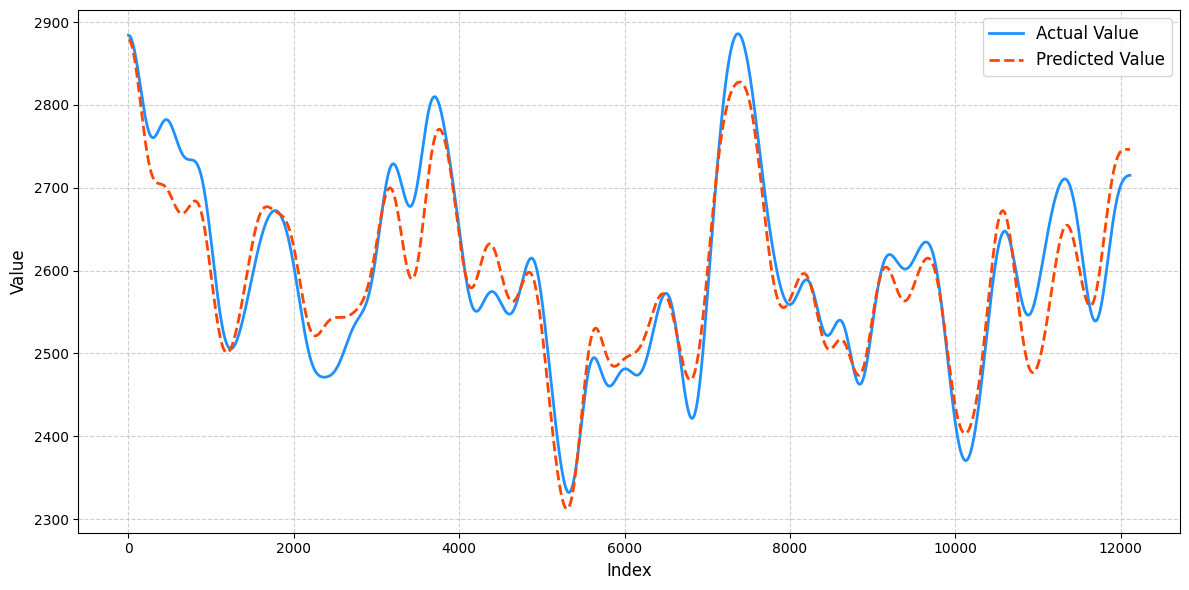

In [7]:
ml.run_model('knn','line')


Performance for knn:
Config: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'leaf_size': 30, 'p': 2}
Mean Squared Error: 1086710.7968
Mean Absolute Error: 482.7071
R² Score: 0.8239


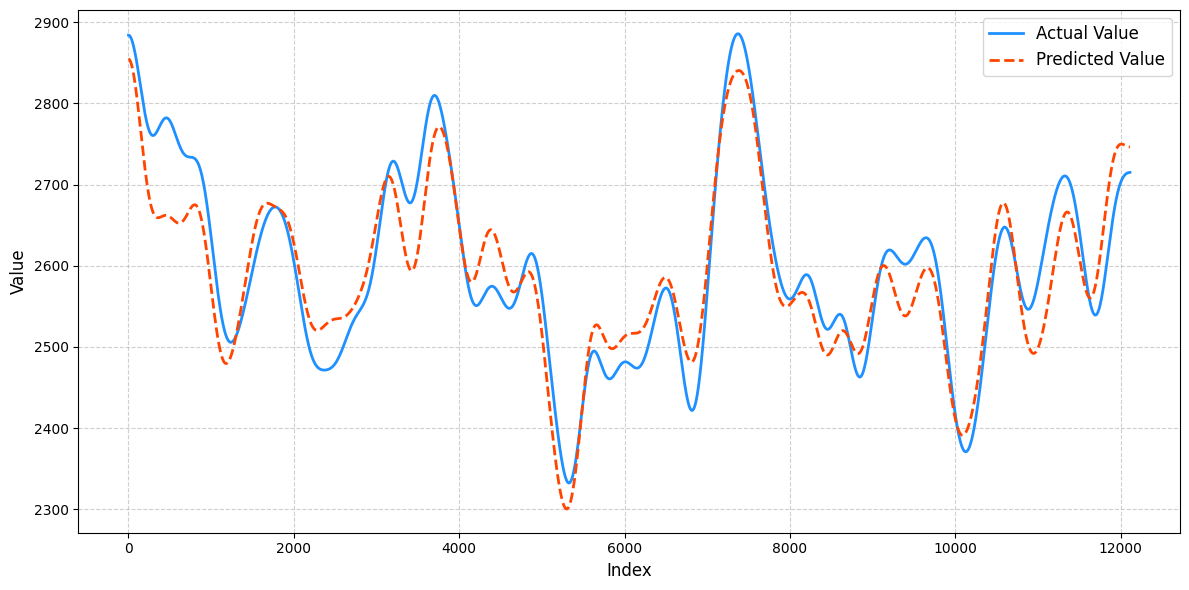

In [8]:
ml.update_config('knn',{"n_neighbors" : 5})
ml.run_model('knn','line')

## Elasticnet



Performance for elasticnet:
Config: {'alpha': 1, 'l1_ratio': 0.5, 'fit_intercept': True, 'max_iter': 1000, 'tol': 0.001}
Mean Squared Error: 3265809.4402
Mean Absolute Error: 1315.4230
R² Score: 0.4709


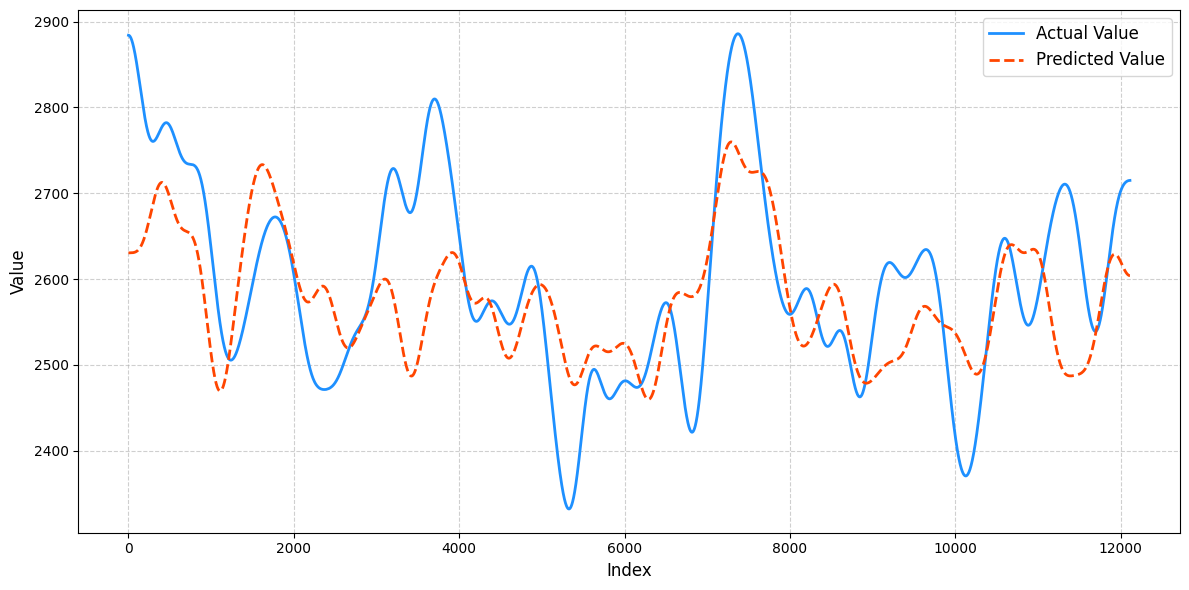

In [9]:
ml.run_model('elasticnet','line')

## MLP


Performance for mlp:
Config: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'max_iter': 500}
Mean Squared Error: 2200627.7579
Mean Absolute Error: 994.2604
R² Score: 0.6435


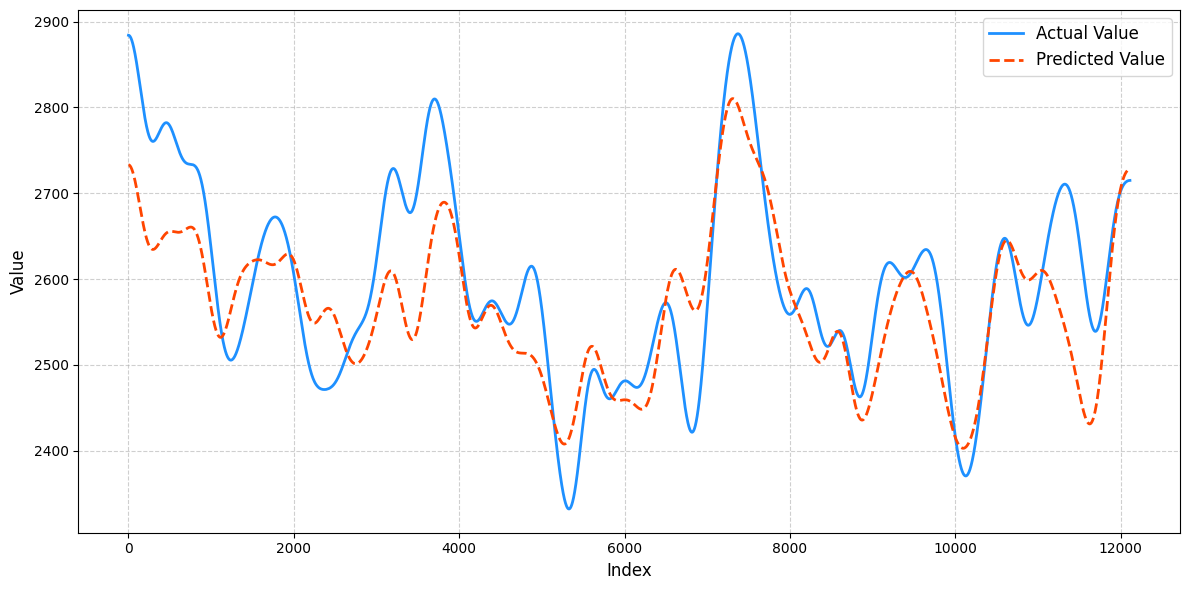

In [10]:
ml.run_model('mlp','line')

## Decision Tree


Performance for decisiontree:
Config: {'criterion': 'squared_error', 'max_depth': 20, 'min_samples_split': 3}
Mean Squared Error: 1189635.6134
Mean Absolute Error: 413.5828
R² Score: 0.8073


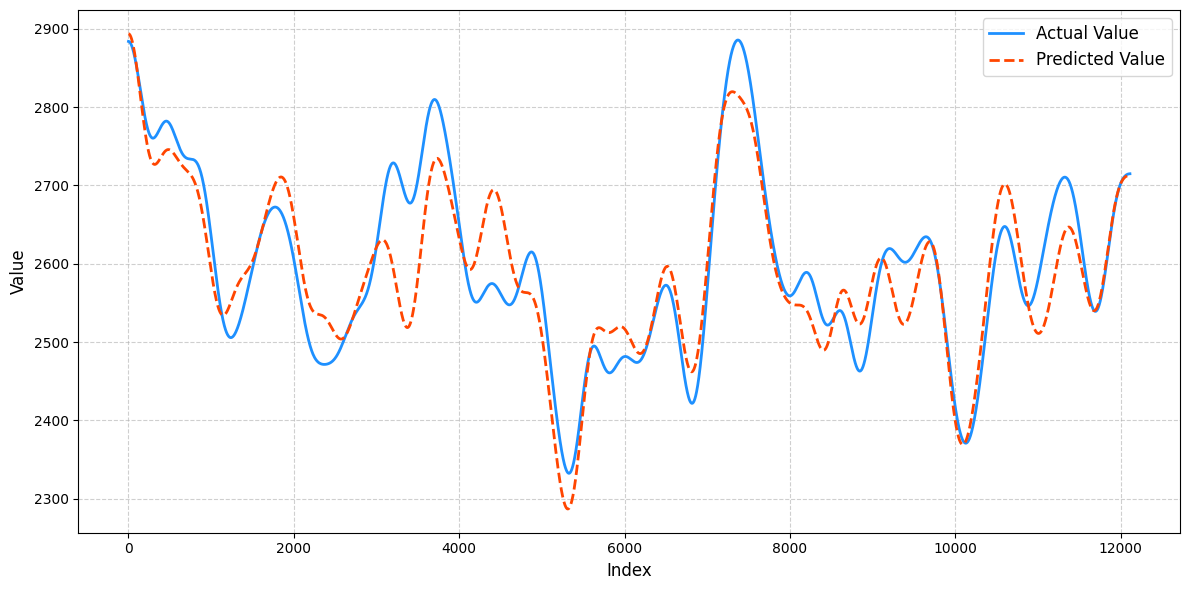

In [11]:
ml.run_model('decisiontree','line')

## Extratrees


Performance for extratrees:
Config: {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 2, 'random_state': 42}
Mean Squared Error: 833444.0595
Mean Absolute Error: 381.4781
R² Score: 0.8650


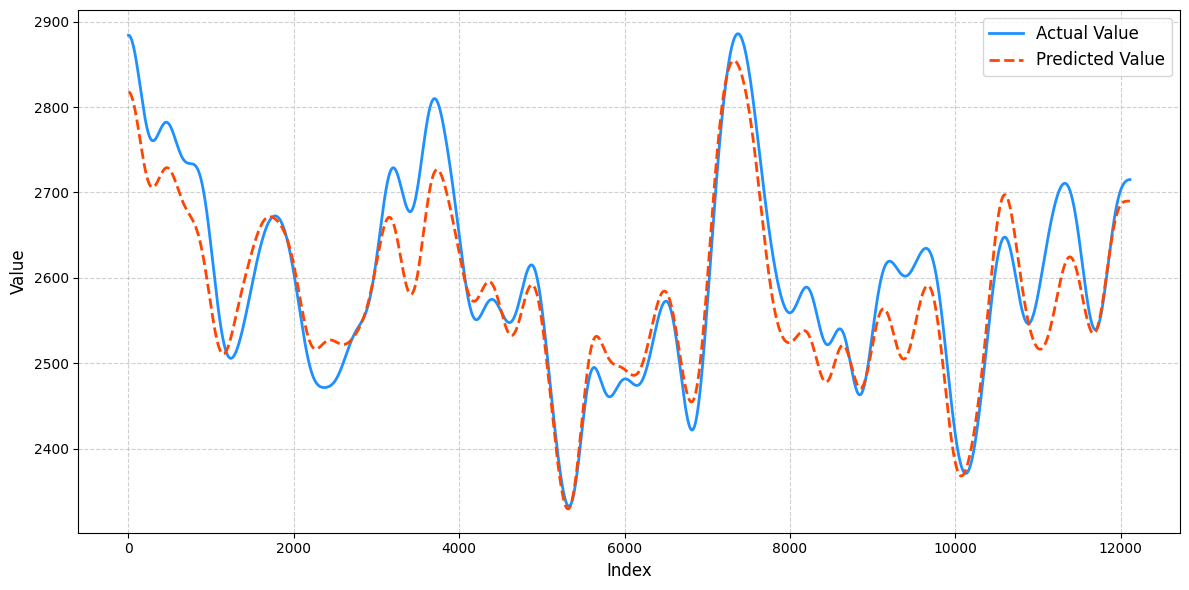

In [13]:
ml.run_model('extratrees','line')

## Random Forest


Performance for randomforest:
Config: {'n_estimators': 100, 'criterion': 'squared_error', 'max_depth': None, 'min_samples_split': 2}
Mean Squared Error: 786686.0669
Mean Absolute Error: 384.7899
R² Score: 0.8725


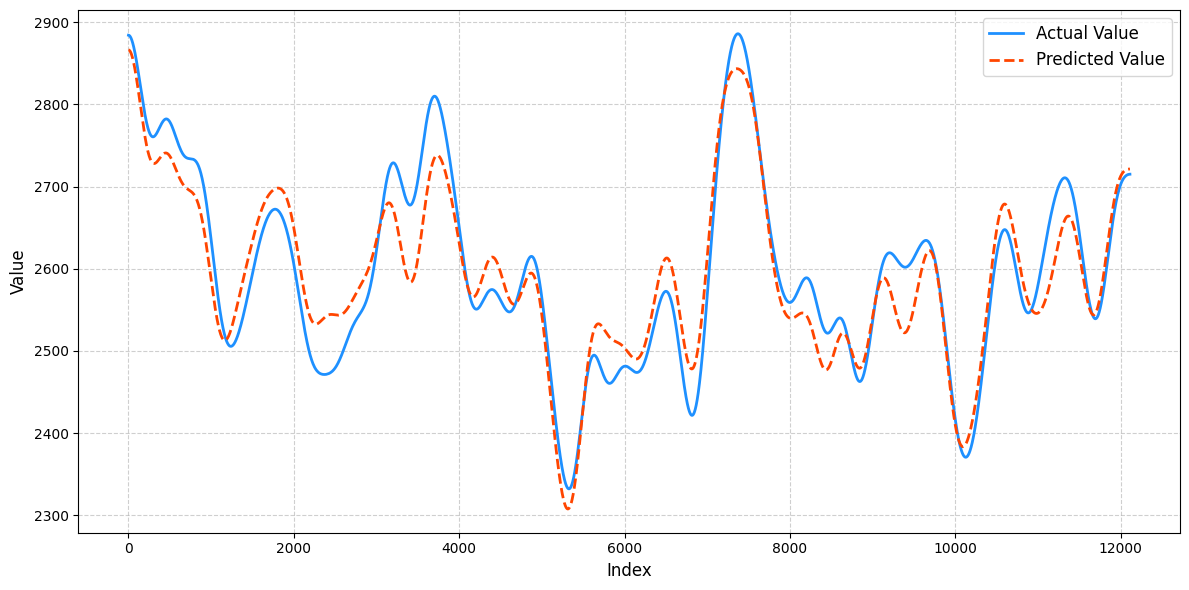

In [14]:
ml.run_model('randomforest','line')

## Normal Stacking

Key on Test Set


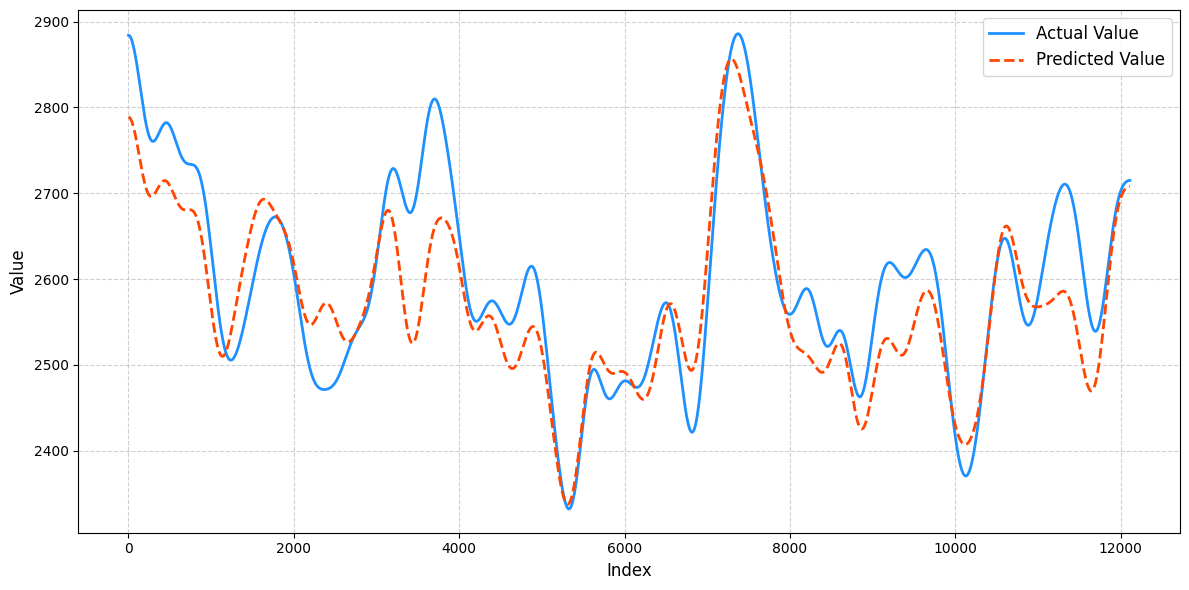

Predict on Test Set
MAE:  634.0548387236316
RMSE:  1049.5635174845684
R2:  0.8215195900560927


In [15]:
model2 = Dynamic_Weighted_Ensemble(X_train,X_val,X_test,Y_train,Y_val,Y_test)

model2.meta_model_name = 'xgboost'
model_combinations = [
    ['lasso', 'gradientboosting', 'mlp', 'extratrees', 'randomforest', 'xgboost']
]

model2.num_sub = len(model_combinations)
model2.init_base_sub(model_combinations)

sub_ensemble_result2 = model2.run_model()


## HDEP

Key on Test Set


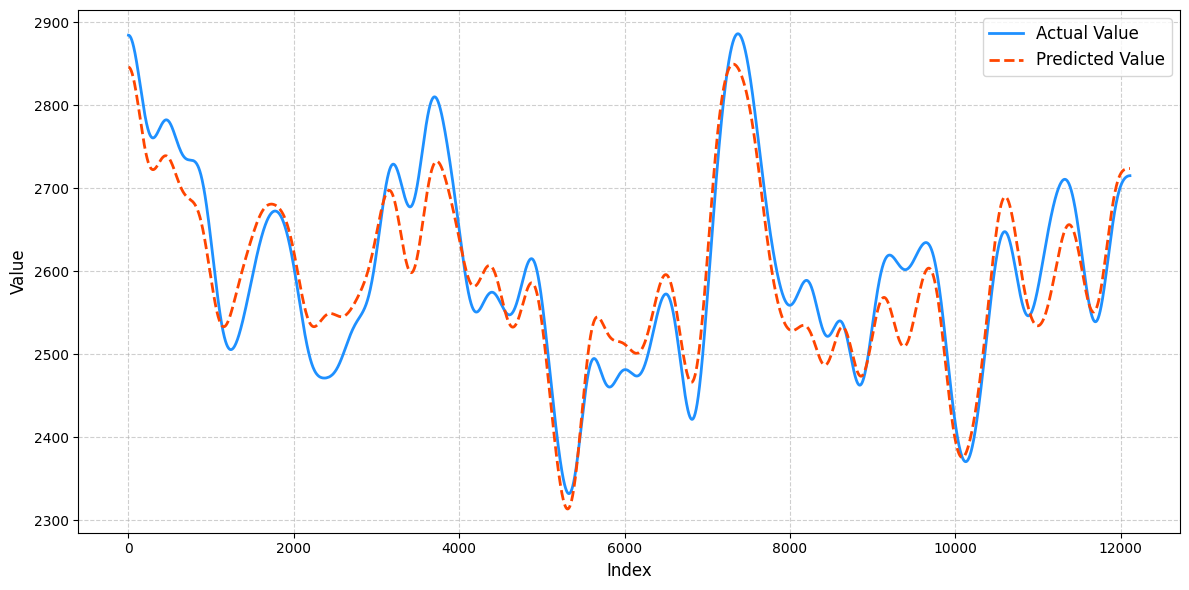

Predict on Test Set
MAE:  400.7879360479167
RMSE:  898.1031324183476
R2:  0.8693150655522117


In [16]:
model = Dynamic_Weighted_Ensemble(X_train,X_val,X_test,Y_train,Y_val,Y_test)

model.meta_model_name = 'gradientboosting'
# model.meta_model_name = 'randomforest'
model_combinations = [['extratrees', 'randomforest', 'xgboost'], ['randomforest', 'mlp', 'gradientboosting'], ['lasso', 'xgboost', 'extratrees']]

model.num_sub = len (model_combinations)
model.init_base_sub(model_combinations)
sub_ensemble_result = model.run_model()



## Compared All Model

In [18]:
model3 = Dynamic_Weighted_Ensemble(X_train,X_val,X_test,Y_train,Y_val,Y_test)
metric = model3.ml.compare_models(['knn',"linearreg",'mlp','decisiontree','xgboost','gradientboosting','extratrees','lasso','catboost'])
filtered_sub_ensemble_result = {k: v for k, v in sub_ensemble_result.items() if k != "result"}
filtered_sub_ensemble_result2 = {k: v for k, v in sub_ensemble_result2.items() if k != "result"}
metric.append(filtered_sub_ensemble_result)
metric.append(filtered_sub_ensemble_result2)
performance_df = pd.DataFrame(metric)
performance_df.sort_values(by="R² Score", ascending=False, inplace=True)
performance_df

,Model,RMSE,MAE,R² Score
9,HDEP,898.103132,400.787936,0.869315
6,EXTRATREES,912.931574,381.478075,0.864964
0,KNN,1033.730015,459.059275,0.826864
10,Normal Stacking,1049.563517,634.054839,0.821520
3,DECISIONTREE,1098.461327,415.613885,0.804502
8,CATBOOST,1126.115166,682.802660,0.794535
5,GRADIENTBOOSTING,1205.311397,752.314277,0.764619
4,XGBOOST,1210.903055,751.767660,0.762430
2,MLP,1469.059059,960.734517,0.650335
7,LASSO,1807.115325,1315.450942,0.470891
